In [51]:
import langchain

# Load & process
from langchain.document_loaders import DirectoryLoader, PyPDFLoader
from langchain.text_splitter import TokenTextSplitter

# Vector store & embeddings
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings

# Conversations
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain
from langchain.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
    SystemMessagePromptTemplate,
)
from langchain.memory import ConversationBufferMemory
from langchain.output_parsers.json import SimpleJsonOutputParser
from langchain.llms import OpenAI

# Post-processing
import fitz

# Token counter
import tiktoken
encoder = tiktoken.encoding_for_model("text-embedding-ada-002")
from langchain.callbacks.manager import get_openai_callback

In [52]:
# Load PDF
loader = PyPDFLoader('pdfs/2309.13963.pdf')
docs = loader.load()

In [54]:
# Split into chunks
text_splitter = TokenTextSplitter(
    chunk_size = 1000,
    chunk_overlap  = 200
)

chunks = text_splitter.split_documents(docs)

# Create embeddings from chunks
embeddings = OpenAIEmbeddings()
docsearch = Chroma.from_documents(chunks, embeddings)

In [55]:
# LLM
chat_model = ChatOpenAI()

# Template prompt
template = """Based ONLY on the context below, answer the following question according to the given format!
Context:
{context}

Question:
{question}

Format: a dictionary with keys
    "answer": (answer to the question)
    "in-text citation": (provide the in-text citation for the source within the context, usually in the form of [number], LEAVE IT BLANK IF NO IN-TEXT CITATION IS AVAILABLE IN THE ANSWER SOURCE)
    "source" : (one sentence that serves as the source of the answer, write it exactly as it appears in the context, including new line (-\n or \n) if any, LEAVE IT BLANK IF NO ANSWER IS AVAILABLE IN THE CONTEXT)
"""

# Prompt
prompt = ChatPromptTemplate(
    messages=[
        SystemMessagePromptTemplate.from_template(
            "You are a nice chatbot having a conversation with a human."
        ),
        MessagesPlaceholder(variable_name="chat_history"),
        HumanMessagePromptTemplate.from_template(template),
    ]
)

# Memory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

In [56]:
def contexts_formatter(contexts):
    result = ""
    for i in range(len(contexts)):
        result += f"{i+1}. {contexts[i].page_content}\n\n\n"
    return result

In [57]:
json_parser = SimpleJsonOutputParser()
chain = prompt | chat_model | json_parser

In [58]:
question = "jelasin apa itu q-former"
contexts = docsearch.similarity_search(question, k=3)

old_answer = ""
len_ans = len(old_answer)

for res in chain.stream({"context": contexts_formatter(contexts), "question": question, "chat_history": memory.buffer_as_messages}):
    if res:
        answer = res["answer"]
        new_answer = answer[len_ans:]
        print(new_answer, end="", flush=True)
        old_answer = res["answer"]
        len_ans = len(old_answer)

# with get_openai_callback() as cb:
#     res_invoke = chain.invoke({"context": contexts_formatter(contexts), "question": question, "chat_history": memory.buffer_as_messages})

Q-Former is a Transformer-based module that converts variable-length input sequences into fixed-length output query representations.

In [59]:
res

{'answer': 'Q-Former is a Transformer-based module that converts variable-length input sequences into fixed-length output query representations.',
 'in-text citation': '[20]',
 'source': 'Q-Former [20] is a Transformer-based module converting variable-length input sequences into fixed-length output query representations.'}

In [60]:
import json

def dict_to_string(input_dict):
    json_string = json.dumps(input_dict, indent=2)  # indent for pretty formatting (optional)
    return json_string

In [61]:
from forex_python.converter import CurrencyRates

def get_cost(
        model="gpt-3.5-turbo", 
        prompt_formatted=prompt.format(context=contexts_formatter(contexts), question=question, chat_history=memory.buffer_as_messages),
        output_from_llm=dict_to_string(res)
):
    curr = CurrencyRates()
    encoder = tiktoken.encoding_for_model(model)
    input_tokens_used = len(encoder.encode(prompt_formatted)) + 7 # Jaga-jaga
    output_tokens_used = len(encoder.encode(output_from_llm))
    total_token = input_tokens_used + output_tokens_used

    input_price = round((0.0015/1000) * input_tokens_used, 8)
    output_price = round((0.002/1000) * output_tokens_used, 8)
    total_price_usd = round(input_price + output_price, 8)
    total_price_idr = curr.convert('USD', 'IDR', total_price_usd)


    return f"""Tokens Used: {total_token}
        Prompt Tokens: {input_tokens_used}
        Completion Tokens: {output_tokens_used}
    Total Cost (USD): ${total_price_usd}
    Total Cost (IDR): Rp{total_price_idr}
    """

In [62]:
# Highlighting Sources
def get_matches(source, contexts=contexts, k=3):
    for i in range(k):
        idx_awal = contexts[i].page_content.find(source)
        if idx_awal != -1:
            idx_akhir = contexts[i].page_content[idx_awal:].find(".")
            idx_akhir += idx_awal
        
            match_ = contexts[i].page_content[idx_awal:idx_akhir]
            if len(match_) > 10:
                page_num = contexts[i].metadata["page"]
                return contexts[i].page_content[idx_awal:idx_akhir], page_num
    else:
        return None
    
def highlight_pdf(path, match_, page_num, output_path):
    pdf = fitz.open(path)
    page = pdf[page_num]

    matches = page.search_for(match_.replace("-\n", ""))

    for m in matches:
        page.add_highlight_annot(m)

    pdf.save(output_path)
    pdf.close()
    

In [63]:
# Get references
def get_reference(docs, in_text_citation):
    model = OpenAI()

    get_citation_template = """From the reference list below, rewrite the specified references!
    References:
    {references}

    Please rewrite the references related to the following numbers:
    {in_text_citation}
    """

    GET_CITATION_PROMPT = PromptTemplate.from_template(get_citation_template)

    get_reference_chain = chain = GET_CITATION_PROMPT | model

    for page_number in range(len(docs)):
        page = docs[page_number]
        text = page.page_content

        if "References" in text or "REFERENCES" in text:
            references_text = text.split("References")[1] if "References" in text else text.split("REFERENCES")[1]

    result = get_reference_chain.invoke({"references": references_text, "in_text_citation":in_text_citation})
    return result

In [65]:
if res["source"]:
    match_, page_num = get_matches(res["source"][:15], contexts)

    if match_:
        highlight_pdf("pdfs/2309.13963.pdf", match_, page_num, "pdfs/highlighted/high_pdf1.pdf")

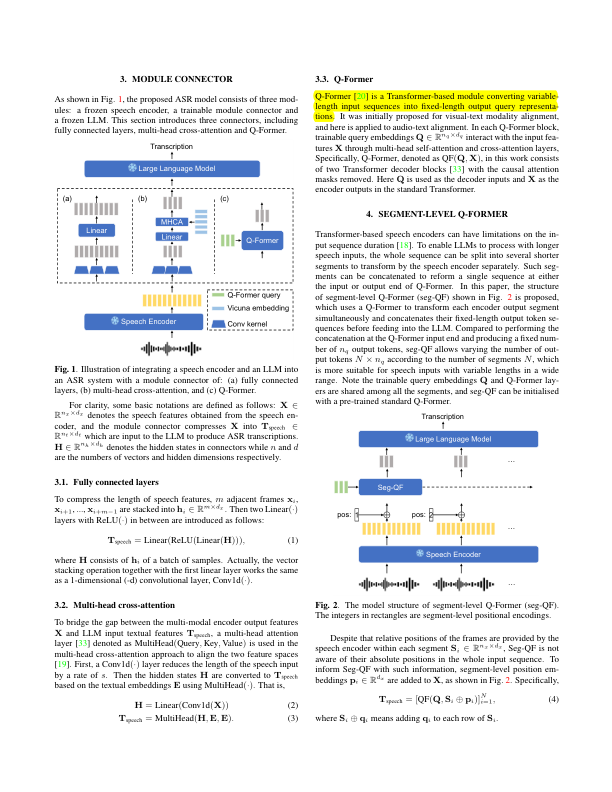

In [66]:
from PIL import Image as PILImage
from IPython.display import display
def display_highlighted_page(path, page_num, output_image_path):

    with fitz.open(path) as highlighted_pdf:
        highlighted_page = highlighted_pdf[page_num]
        pix = highlighted_page.get_pixmap()
        img = PILImage.frombytes("RGB", [pix.width, pix.height], pix.samples)
        img.save(output_image_path)

    display(PILImage.open(output_image_path))

pdf_path = "pdfs/2309.13963.pdf"
output_pdf_path = "pdfs/highlighted/high_pdf1.pdf"
output_image_path = "pdfs/highlighted/high_pdf_highlighted.png"

highlight_pdf(pdf_path, match_, page_num, output_pdf_path)
display_highlighted_page(output_pdf_path, page_num, output_image_path)

In [ ]:
if res["in-text citation"]:
    ref_result = get_reference(docs, res["in-text citation"]).strip()
print(ref_result)

[20] J. Li, D. Li, S. Savarese, and S. Hoi, “BLIP-2: Bootstrapping Language-Image Pre-training with Frozen Image Encoders and Large Language Models,” in Proc. ICML , Vienna, 2023.
